## STOCHASTIC MODELING
MODULE 2 | LESSON 4


---


# **CALIBRATING BATES (1996)** 


|  |  |
|:---|:---|
|**Reading Time** |  75 minutes |
|**Prior Knowledge** | Merton model, Heston model, Fourier transform, Characteristic function, Bates model  |
|**Keywords** | Bates, Lewis, Calibration |


---

*In Lesson 4 of Module 2 of Stochastic Modeling we will use Lewis (2001) approach to fully calibrate Bates (1996) model based on real option market quotes for the EuroStoxx 50, as we have done before for other models. Different from the calibrations we have done so far, Bates (1996) requires a sequential procedure, whereby we first calibrate the stochastic volatility component of a Heston (1993) type of model. Then, we use those parameters to calibrate the jump component of Bates (1996). Finally, we calibrate, via local optimization, the general model.*

As usual, let's start with the import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin

## 1. Calibrate Heston (1993) stochastic volatility model

We already know that Bates (1996) model combines two desirable features: stochastic volatility of Heston (1993) and jump component from Merton (1976). Thus, as we know, the characteristic function, $\varphi^{B96}( )$, of Bates (1996) is given by:

$$
\
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

\
As we also know, $\varphi^{H93}_0$ stands for the characteristic function of Heston (1993). Thus, our first task in calibrating the Bates (1996) model will be to calibrate Heston (1993) model to observed market data. This is actually something we have already done before in Module 1 of the Stochastic Modeling course. Please, go there to revisit the calibration of Heston (1993) model to market prices of EuroStoxx 50 options. 

\
At this point, we assume that you know how to do the Heston calibration, so we will take advantage of the opportunity to introduce a python file format that some of you may be already familiar with, but that will come in handy in your data handling tasks: `.npy`

This is basically a Numpy format, you can check more about it here:
https://numpy.org/devdocs/reference/generated/numpy.lib.format.html

Now, the good thing about this file formatting is that it is extremely fast to read and load by python, so it can saves us a ton of time when we work with large numerical data sets. You can read more about its speed here:
https://www.kdnuggets.com/2018/04/start-using-npy-files-more-often.html

\
So, suppose that we have performed the calibration of Heston (1993) model and we have saved the parameters from stochastic volatility model in a `.npy` file using the `np.save( )` feature. We can simply load those parameters from the file (`opt_sv.npy`) now in order to perform our next task:

In [1]:
kappa_v, theta_v, sigma_v, rho, v0 = np.load("opt_sv_M2.npy")

NameError: name 'np' is not defined

Let's see how those parameters look like:<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [ ]:
print(kappa_v, theta_v, sigma_v, rho, v0)

18.447069109136955 0.025919335092243055 0.9778913699421999 -0.8205174711934705 0.03516507923484203


So, this is the parameters resulting from calibration of the Heston (1993) model:

- $\kappa_\nu = 18.447$
- $\theta_\nu = 0.026$
- $\sigma_\nu = 0.978$
- $\rho = -0.8218$
- $\nu_0 = 0.035$

\
We will now use these parameters to calibrate the jump component of the model.


## 2. Calibrate jump component in Bates (1996)

After we have run the first calibration process for the basic Heston (1993) model, we will take the parameters obtained and used them to calibrate the jump component in Bates (1996). For this task, first thing we need is to obtain option market data. As we have done so many times before, let's use our sample data from EuroStoxx 50 index equity options.


## 2.1. Getting options market data

This process is virtually the same we have done for loading options market data many times before:

\
First, we load option market data from the file `option_data_wqu.h5`:

In [4]:
# Option market data loading
h5 = pd.HDFStore("option_data_M2.h5", "r")
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level 30.09.2014

Second, we select the options near ATM we are going to take into account in our calibration procedure:

In [ ]:
# Set tolerance level for near ATM options
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

C:\Users\USER\AppData\Local\Temp\ipykernel_9552\2309975757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Date"] = pd.DatetimeIndex(options["Date"])
C:\Users\USER\AppData\Local\Temp\ipykernel_9552\2309975757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Maturity"] = pd.DatetimeIndex(options["Maturity"])


Third, we add time-to-maturity and short interest rates to work with later:

In [6]:
# Adding Time-to-Maturity and constant short-rates
for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.02

C:\Users\USER\AppData\Local\Temp\ipykernel_9552\2315811583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "T"] = T
C:\Users\USER\AppData\Local\Temp\ipykernel_9552\2315811583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "r"] = 0.02


Finally, for illustrative purposes, we are going to work with the closest maturity available, which in this sample dataset is 17 days:

In [ ]:
# Select closest maturity
mats = sorted(set(options["Maturity"]))
options = options[options["Maturity"] == mats[0]]

In [ ]:
time_to_mat = options["Maturity"].iloc[0] - options["Date"].iloc[0]
time_to_mat

Timedelta('17 days 00:00:00')

This is how our market data looks like, a dataset you should already be familiar with:

In [9]:
options.head(5)

,Date,Strike,Call,Maturity,Put,T,r
456,2014-09-30,3175.0,82.3,2014-10-17,24.5,0.046575,0.02
457,2014-09-30,3200.0,64.3,2014-10-17,31.5,0.046575,0.02
458,2014-09-30,3225.0,48.3,2014-10-17,40.5,0.046575,0.02
459,2014-09-30,3250.0,34.6,2014-10-17,51.8,0.046575,0.02
460,2014-09-30,3275.0,23.5,2014-10-17,65.8,0.046575,0.02


## 2.2. Problems in calibrating the jump component

Now, we have already calibrated a jump-diffusion model when we looked at Merton (1976) at the beginning of the module. At this point, we bring up a couple of drawbacks related to the calibration of these type of models. 

There are two basic flaws related to the calibration of jump diffusion (and other) type of models. Probably you have think of these by yourselves already:

- 1. Different combinations of parameter values may yield same (or very similar) values for the error function.

- 2. We may encounter many local minima in the error function, making it difficult for the algorithm to decide.

Overall, these two problems sum up to the fact that we can find very different parameters values when we come back to recalibrate our model. Thus the challenge of finding stable parameters in our calibrations. This is key in practice not only for pricing, but, more importantly, for hedging.

\
For more information on these, you can check, among others, the Galluccio and Le Cam (2008) paper freely available here:
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=831784


## 2.3. Regularization of the error function

In order to try mitigate the aforementioned issues, a technique that practitioners usually implement is regularization of the error function. There are many way to do this in order to obtain more stable calibrated parameters. In here we will follow a classic: Tikhonov regularization (general info here: https://en.wikipedia.org/wiki/Tikhonov_regularization)

In our setting, Tikhonov regularization basically consists on imposing a **penalty term** to the local optimization error function. This penalty function will have the following form:


$$
    Penalty \ (p) \equiv \sqrt{(p_0 - p)^2}$$

\
with $p_0$ being the vector of initial parameter values and $p$ the current vector.

Thus, if we relied on a minimum squared error (MSE) function for our optimization, the regularized error function will be:

$$
    \min_p \frac{1}{N} \sum_{n=1}^{N} \left( C_n^* - C^{B96}_n(p) \right)^2 + ω \ Penalty (p)
$$

\
where, as usual, $C_n^*$ is the option's market price, and $C^{B96}_n(p)$ stands for the model option price under parameter vector $p$. We can use $\omega$ to give more or less importance to the penalty.

Note that with this enhanced error function we are introducing a penalty for deviating from initial input values (that could come, for example, from previous calibrations of the model), so that the optimization process behaves in a more stable way, avoiding, unless strictly necessary, large difference in the parameters from initial values.


## 2.4. Calibration of the jump component

So, let's finally perform the calibration of the jump component. For that, we will proceed as usual, with a few minor twitches.

### 2.4.1. Error function

Let's start by setting calibration parameters and defining the error function, which obviously will be looking at differences between market and model prices for the complete Bates (1996) model:

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

In [2]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

### 2.4.2. Option pricing functions

Obviously, for this error function to being able to compute model option prices we also need to import or load the different functions used in the pricing via Bates (1996) model. This is no different from what we did in the previous lesson so you could just copy here those same functions. First, for the value of the option:

In [12]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

And then of course for the different characteristic functions and computation of the Lewis (2001) integral:

In [9]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [10]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [11]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [7]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

### 2.4.3. Calibration functions

Finally, we can create our functions to calibrate the jump component of the model:

In [8]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

Let's execute this optimization to see the values for the jump component calibration:

In [18]:
params = B96_calibration_short()

   0 | [ 0.  -0.5  0. ] |   2.575 |   2.575
  25 | [ 0.2  -0.5   0.25] |  62.394 |   2.575
  50 | [ 0.4 -0.5  0.5] | 233.890 |   2.575
  75 | [ 0.0e+00 -5.0e-01  2.5e-04] |   2.575 |   2.575
 100 | [ 7.45058060e-12 -5.08333333e-01  8.33333308e-05] |   2.575 |   2.575
 125 | [ 0.        -0.5015625  0.       ] |   2.575 |   2.575
 150 | [ 0.00000000e+00 -5.00000000e-01  2.44140625e-07] |   2.575 |   2.575
 175 | [ 5.55111512e-20 -5.00000127e-01  1.27156576e-09] |   2.575 |   2.575
Optimization terminated successfully.
         Current function value: 2.575480
         Iterations: 55
         Function evaluations: 166


What are the parameter values from this calibration?

In [19]:
params

array([ 0. , -0.5,  0. ])

So it seems that calibrating the jump component yields:

In [20]:
lamb = 0
mu = -0.5
delta = 0

### 2.4.4. Model vs. Market prices after jump calibration

Now, let's see how our model prices fit the observed market prices after this 2 step calibration process.

\
For that, we first create a function that yields the model values under the different parameters obtained in the calibration process:

In [21]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        T = (option["Maturity"] - option["Date"]).days / 365.0
        r = 0.02
        model_value = B96_call_value(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

Next, let's create another to plot the results:

In [22]:
def plot_calibration_results(p0):
    options["Model"] = B96_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

And plot them...

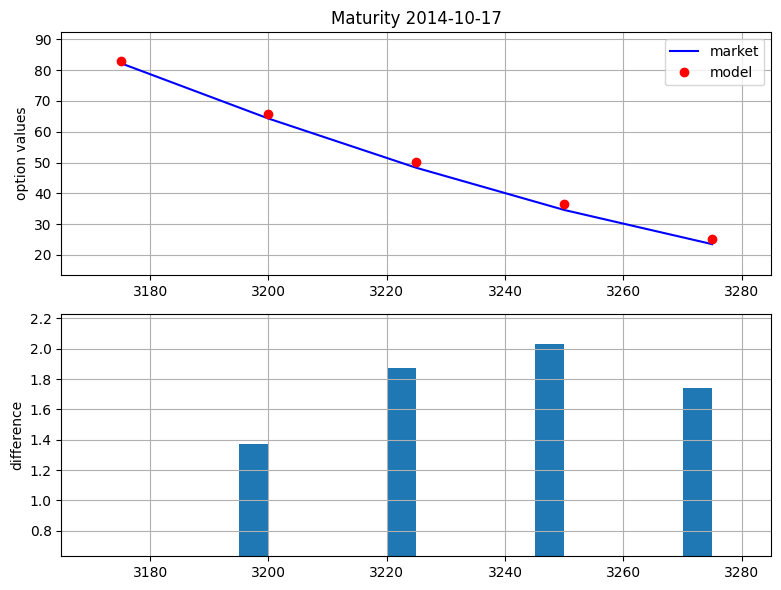

In [23]:
plot_calibration_results(params)


## 3. Full Bates (1996) model calibration

For the final step of this lengthy calibration process, we can repeat the process of using the previously calibrated values as inputs for the full calibration of the model. 

In this case, our inputs will not only consist on the parameters from the stochastic volatility model ($\kappa_\nu$, $\theta_\nu$, $\sigma_\nu$, $\rho$, $\nu_0$), but also those from the jump component ($λ$, $\mu$, $\delta$).

Hence, our $p_0$ is defined as:

In [24]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

Now, we cam build up a *B96_full_error_function* that essentially takes these inputs and calculate the error function. Note that here we do not impose any penalties on the error function, as it solved an inherent problem of the jump diffusion model that should be already solved by using the initial inputs from the jump component calibration.

There are indeed many more issues that we could consider in the optimization program and the error function. We will deal with these later on in the course and in future courses. For now, let's define the error function:

In [30]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

Next, the classic calibration we have done before for other models:

In [31]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

And, finally, a function to calculate values under full model calibration:

In [32]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

## 3.1. Full model calibration parameters

Now, we can see what are the different parameter values yielded by this calibration:

In [33]:
full_params = B96_calibration_full()

   0 | [18.44706911  0.02591934  0.97789137 -0.82051747  0.03516508  0.
 -0.5         0.        ] |   2.575 |   2.575
  25 | [ 1.89196546e+01  2.66353670e-02  9.45309145e-01 -8.55622980e-01
  3.01835172e-02  2.65971214e-04 -5.02080393e-01  3.12703375e-04] |   0.768 |   0.164
  50 | [ 1.88912776e+01  2.62162522e-02  9.53512467e-01 -8.47490495e-01
  3.13883965e-02  2.12755936e-04 -5.05850862e-01  2.43397839e-04] |   0.256 |   0.164
  75 | [ 1.88659969e+01  2.45371124e-02  9.58449397e-01 -8.79395537e-01
  3.27722444e-02  1.81806738e-04 -4.99787220e-01  3.17490996e-04] |   0.121 |   0.116
 100 | [ 1.86471208e+01  2.32460445e-02  9.23885953e-01 -9.50793258e-01
  3.32800631e-02  1.62535845e-04 -4.75958591e-01  5.48375076e-04] |   0.101 |   0.100
 125 | [ 1.86204047e+01  2.32470583e-02  9.25942793e-01 -9.47783422e-01
  3.33544512e-02  1.59456557e-04 -4.78243704e-01  5.30355840e-04] |   0.099 |   0.099
 150 | [ 1.86379352e+01  2.33935895e-02  9.33498759e-01 -9.38345133e-01
  3.33228408e-02  1.

C:\Users\USER\AppData\Local\Temp\ipykernel_9552\3962071003.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


Let's check the parameter values:

In [29]:
full_params

array([ 1.77663477e+01,  2.94142961e-02,  1.02232309e+00, -8.74077400e-01,
        3.07828972e-02,  4.37982342e-08, -4.68886712e-01,  6.34155426e-05])

Which basically yields (note that these would slightly change upon small twitches of the code):

- $\kappa_\nu = 18.858$
- $\theta_\nu = 0.0249$
- $\sigma_\nu = 0.961$
- $\rho = -0.917$
- $\nu_0 = 0.0327$
- $\lambda = 0.000$
- $\mu = -0.508$
- $\delta = 0.001$


## 3.2. Market vs. Model prices in full calibration 

As before, let's see what are the differences that our model produces using the parameters resulting from calibration, and compare those to observed market prices:

In [ ]:
def plot_full_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

In [ ]:
plot_full_calibration_results(full_params)

As you can see, the model does a better job in terms of fitting the observed option market prices after the full calibration process. 

Now, we have done this for the shortest (closest) options maturity, can you do it for others?

## 4. Conclusion

In this lesson we have learned about the different steps part of the full calibration of a stochastic volatility jump diffusion model such Bates (1996). It is indeed a challenging tasks that requires that you properly understand all the steps involved. 

By the end of module 2 you should be familiar with models such Bates (1996), that combine stochastic volatility and a jump diffusion. There is still one thing that we have kept fixed and exogenously given so far: interest rates, which models such Bates (1996) do not consider. In the next module, we will explore the case of Bakshi, Cao, and Chen model of 1997 (BCC model), that puts together 3 different features: stochastic volatility, stochastic interest rates, and jumps.


**References**

- Hilpisch, Yves. Derivatives analytics with Python: data analysis, models, simulation, calibration and hedging. John Wiley & Sons, 2015.

- Bates, David S. 'Jumps and stochastic volatility: Exchange rate processes implicit in deutsche mark options'. The Review of Financial Studies 9.1 (1996): 69-107.

- Cherubini, Umberto, et al. Fourier transform methods in finance. John Wiley & Sons, 2010

- Galluccio, Stefano, and Yann Lecam. "Implied calibration and moments asymptotics in stochastic volatility jump diffusion models." Available at SSRN 831784 (2008).

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
